In [1]:
import numpy as np
from copy import deepcopy
import gc
from matplotlib import pyplot as plt
from itertools import product, combinations
import networkx as nx
from collections import defaultdict
gc.collect()
%matplotlib inline

In [14]:
def leave(i):
    #probability of leaving if 1/(i%4+2)^2
    if np.random.rand() < [0.09, 0.07, 0.06, 0.008][i%4]:#(2*(i%4)+1)**(-3):
        return True
    else:
        return False
    
def iterate(partition, fixed=False):
    """
    Argument: 
        p(list) - partition of individuals
    Returns:
        the next generation based on probability rules determined by mod 4
    """
    p = deepcopy(partition)
    num_groups = len(p)
    new_comers = [[] for i in range(num_groups)]
    
    #for indiv in 
    #for i,group in enumerate(p):
    #    for indiv in group:
    #        is_leaving = leave(indiv)
    #        if is_leaving:
    #            group.remove(indiv) #####
    #            new_group = np.random.randint(num_groups-1)
    #            new_group = new_group if new_group < i else new_group + 1
    #            new_comers[new_group].append(indiv)
    #for i in range(num_groups):
    #    p[i].extend(new_comers[i])
    return p

In [53]:
class global_markov_predictor(object):
    def __init__(self, num_indiv=6, num_groups=3, **kwargs):
        """
        Input:
            num_indiv(int) - number of individuals in the model
            num_groups(int) - number of groups in the model
            (optional)
            generations(list of lists) - the generations of partitions
            num_gen(int) - the number of generations to create
        """
        self.num_indiv = num_indiv
        self.num_groups = num_groups
        
        if 'generations' in kwargs:
            v = kwargs['generations']
            self.gen = v
            self.num_gen = len(v)
        elif 'num_gen' in kwargs:
            v = kwargs['num_gen']
            self.num_gen = v
            self.gen = self.make_data()
        else:
            self.num_gen = 50
            self.gen = self.make_data()
            
        self.global_tran = self.global_markov()
            
    def make_data(self):
        s = self
        partition = []#[[] for i in range(s.num_groups)]
        #per_g = max(1, s.num_indiv//s.num_groups)
        for i in range(s.num_indiv):
            #partition[i//per_g%s.num_groups].append(i)
            partition.append(i%s.num_groups)
        gen = [partition]
        for i in range(s.num_gen):
            gen.append(s.iterate(gen[-1]))
        return gen
    
    def iterate(self, partition):
        """
        Argument: 
            p(list) - partition of individuals
        Returns:
            the next generation based on probability rules determined by mod 4
        """
        s = self
        p = deepcopy(partition)
        for indiv in range(s.num_indiv):
            is_leaving = leave(indiv)
            if is_leaving:
                g = p[indiv]
                new_group = np.random.randint(s.num_groups-1)
                new_group = new_group if new_group < g else new_group + 1
                p[indiv] = new_group
        return p

    def group_markov(self):
        #network stuff(group to group analysis)
        s = self
        tran = np.zeros((s.num_groups,s.num_groups))
        for indiv in range(s.num_indiv):
            g1 = s.gen[0][indiv]#= sum(i*(indiv in group) for i,group in enumerate(self.gen[0]))
            for g_ind in range(1,self.num_gen):
                g2 = s.gen[g_ind][indiv]#sum(i*(indiv in group) for i,group in enumerate(self.gen[g_ind]))
                #print(g1,g2,gen[g_ind])
                tran[g1,g2] += 1
                g1 = g2

        #tran = 0.999*tran
        tran += 0.0001
        #print(tran)
        return tran/np.sum(tran,axis=0)

    def partition_difference(self, p1, p2):
        total = 1
        for i in range(self.num_indiv):
            a,b = p1[i],p2[i]
            if a==b:
                total *= self.group_tran[a,b]*(1-self.indiv_tran[i])
            else:
                total *= self.group_tran[a,b]*self.indiv_tran[i]
        return total + 0.0001
    
    def indiv_prob(self):
        prob = [0 for i in range(self.num_indiv)]
        current = self.gen[0]
        for g in self.gen[1:]:
            for i in range(self.num_indiv):
                if current[i] != g[i]:
                    prob[i] += 1/(self.num_gen-1)
            current = g.copy()
        return prob

    def global_markov(self):
        '''
        This is being designed to handle 3 labeled groups and 8 distinct 
        individuals. Already, that requires a 6561x6561 matrix or 
        43,046,721 elements to make the complete Markov chain.
        '''
        s = self
        s.ind_part = {p:i for i,p in enumerate(product(range(s.num_groups),repeat=s.num_indiv))}
        s.part_ind = {i:p for i,p in enumerate(product(range(s.num_groups),repeat=s.num_indiv))}

        s.indiv_tran = s.indiv_prob()
        s.group_tran = s.group_markov()
        global_tran = np.zeros((s.num_groups**s.num_indiv, s.num_groups**s.num_indiv), dtype=np.float64)

        #print(index_partition)
        for (p1,i1),(p2,i2) in product(s.ind_part.items(),repeat=2):
            #print(p1,i1)
            global_tran[i1,i2] = s.partition_difference(p1,p2)
            
        #global_tran *= 0.999
        #global_tran += 0.001/len(global_tran)
        return global_tran/np.sum(global_tran, axis=0)

    def predict_global(self, num_predict=30, current = None):
        s = self
        group_movement = []
        #current = tuple(s.gen[-1])
        if current is None:
            current = tuple(s.gen[-1])
        else:
            current = tuple(current)
        for i in range(num_predict):
            col = s.ind_part[current]
            #print(col, current)
            outcome = np.random.multinomial(1, s.global_tran[:, col])
            k = outcome.argmax()
            current = tuple(s.part_ind[k])
            group_movement.append(current)
        return group_movement
    
    def coarse_grain(self, beta):
        G = nx.DiGraph()
        for i,row in enumerate(mymodel.global_tran):
            for j,p in enumerate(row):
                if p > beta:
                    G.add_edge(i,j,weight=p)
        self.components = list(nx.strongly_connected_components(G))
        return len(self.components), [len(i) for i in self.components], G
    
    def apply_coarse_grain(self):
        temp_part_ind = defaultdict(list)
        temp_ind_part = {}
        m = len(self.components)
        tran = np.zeros((m,m))
        
        for (i,comp1),(j,comp2) in product(enumerate(self.components),repeat=2):
            for x,y in product(comp1,comp2):
                tran[i,j] += self.global_tran[x,y]
        
        for i,comp in enumerate(self.components):
            for p_index in comp:
                part = self.part_ind[p_index]
                #temp_part_ind[i].append(part)
                temp_part_ind[i] = part
                temp_ind_part[part] = i
        
        self.part_ind = temp_part_ind
        self.ind_part = temp_ind_part
        self.global_tran = tran/np.sum(tran,axis=0)

In [54]:
mymodel = global_markov_predictor(num_indiv=6, num_groups=3)
print(mymodel.group_tran)
print(mymodel.indiv_tran)
mat = mymodel.global_tran

[[ 0.93103294  0.05504664  0.02898683]
 [ 0.03448353  0.91742959  0.0724649 ]
 [ 0.03448353  0.02752378  0.89854827]]
[0.16326530612244897, 0.061224489795918366, 0.061224489795918366, 0, 0.12244897959183672, 0.1020408163265306]


In [56]:
movement = np.array(mymodel.predict_global(num_predict=50, current=mymodel.gen[0]))
movement[-1] = np.array([0,1,2,0,1,2])

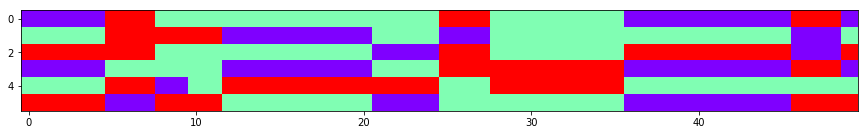

In [57]:
plt.figure(figsize=(15,4))
plt.imshow(movement.T, cmap='rainbow')
plt.show()
#print(movement.T)

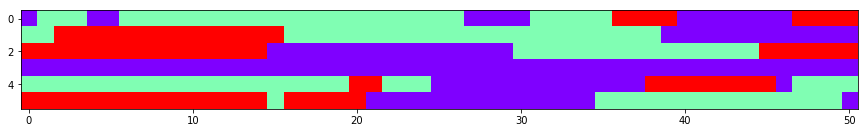

In [58]:
## print("Actual Change")
generation = np.array(mymodel.gen)
plt.figure(figsize=(15,8))
plt.imshow(generation.T, cmap='rainbow')
plt.show()
#print(generation.T[:,:50])

In [49]:
n, l, g = mymodel.coarse_grain(0.002)
print(n, sum(l), l)


324 2187 [3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3, 6, 6, 12, 3,

In [105]:
mymodel.apply_coarse_grain()

In [128]:
print(np.median(mymodel.global_tran.ravel()))
print(np.average(mymodel.global_tran))
#print(mymodel.global_tran.diagonal())

0.0
0.0009765625


In [25]:
mymodel.gen[-1]

[3, 1, 3, 3, 2]

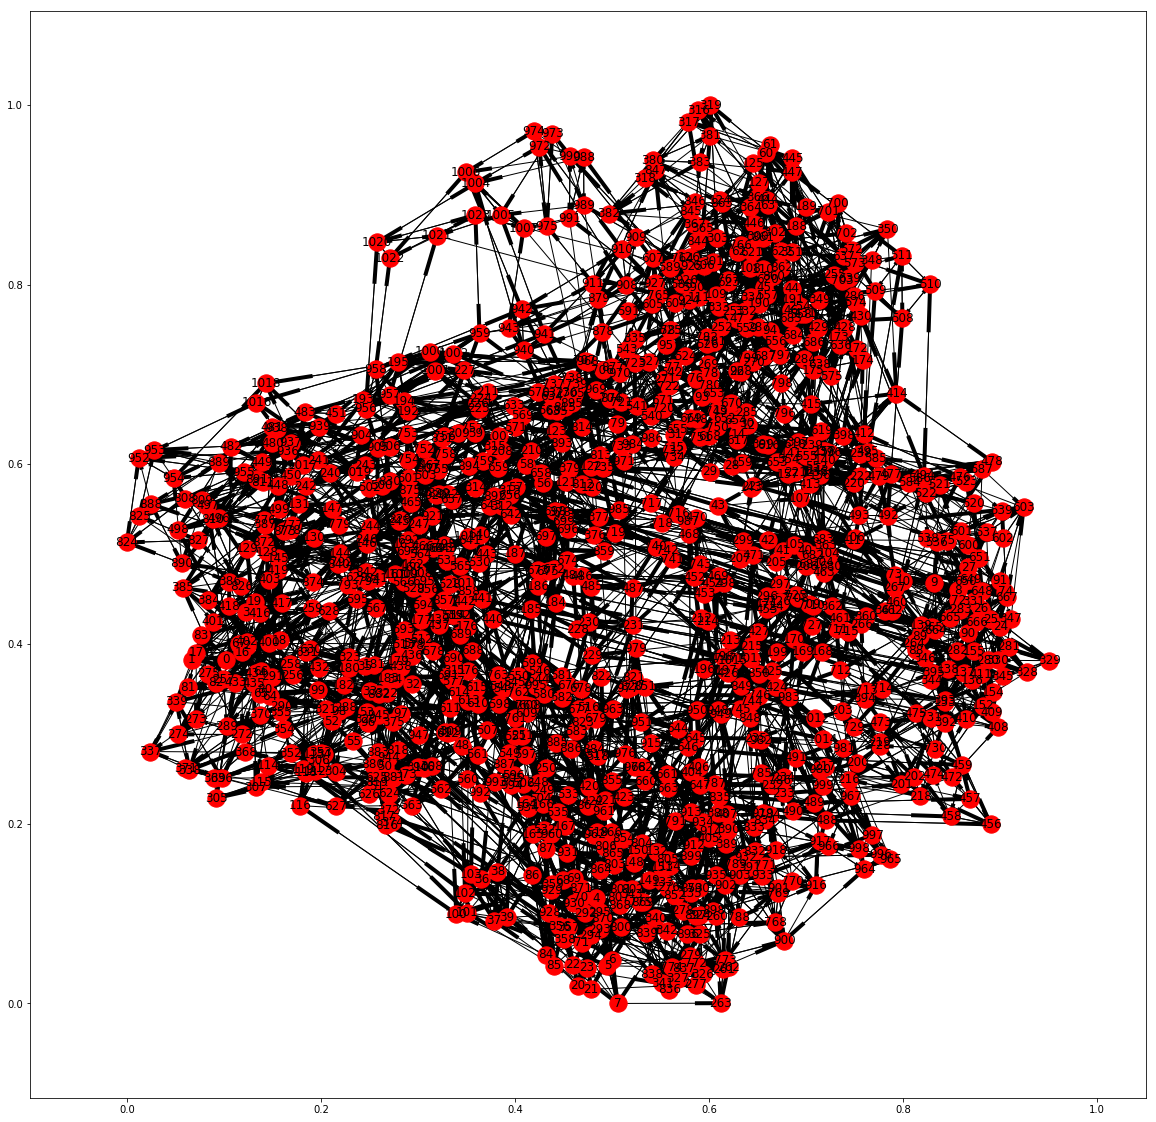

In [119]:
plt.figure(figsize=(20,20))
nx.draw_networkx(g)
plt.show()

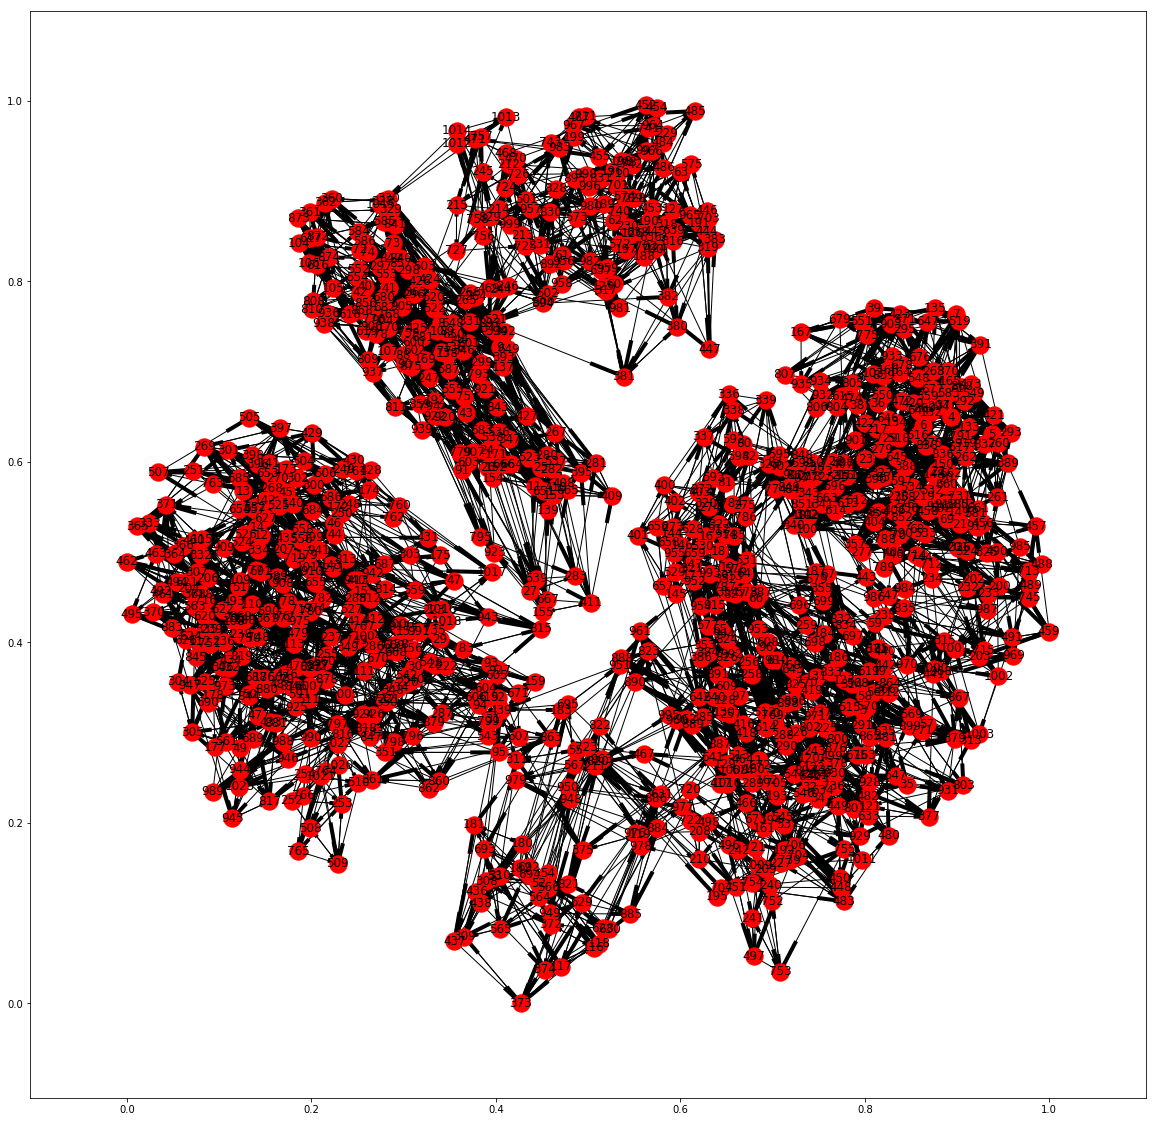

In [75]:
plt.figure(figsize=(20,20))
nx.draw_networkx(g)
plt.show()

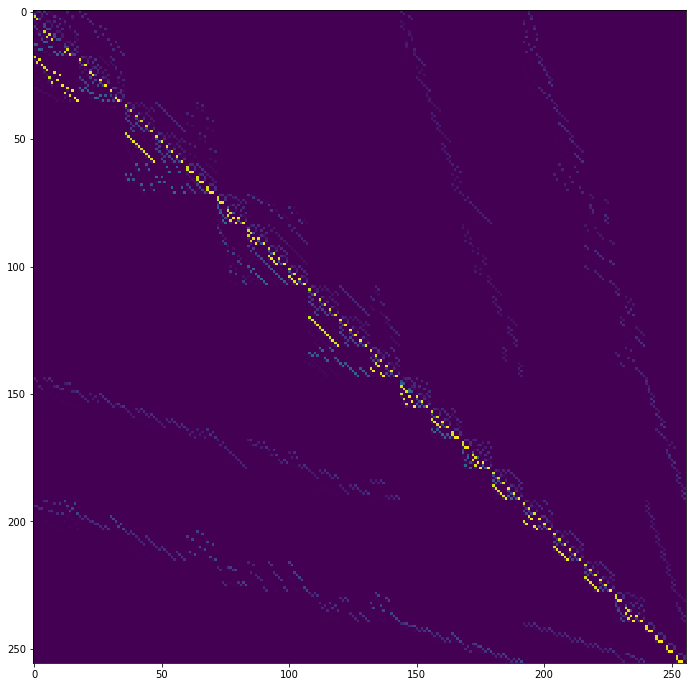

In [109]:
plt.figure(figsize=(12,12))
plt.imshow(mymodel.global_tran*(np.ones_like(mymodel.global_tran)-np.eye(len(mymodel.global_tran))))

In [46]:
import operator as op

In [45]:
operator.mod?

In [47]:
op.add(10,12)

22